In [1]:
import os
import sys
from pathlib import Path
sys.path.insert(1, str(Path(os.getcwd()).parent / "src"))

In [2]:
import data_loader
from concentr_diffs_pathlength import *
from plotting import *
from mbll_functions import *
from utils import *
from mcs_function import *
from pathlib import Path
import config
import pickle
from scipy.optimize import least_squares
import pmcx
from tqdm.notebook import tqdm
import imageio

import matplotlib.pyplot as plt

In [3]:
pmcx.gpuinfo()

=============================   GPU Information  ================================
Device 1 of 1:		NVIDIA GeForce GTX 1050
Compute Capability:	6.1
Global Memory:		4237164544 B
Constant Memory:	65536 B
Shared Memory:		49152 B
Registers:		65536
Clock Speed:		1.49 GHz
Number of SMs:		5
Number of Cores:	640
Auto-thread:		10240
Auto-block:		64


[{'name': 'NVIDIA GeForce GTX 1050',
  'id': 1,
  'devcount': 1,
  'major': 6,
  'minor': 1,
  'globalmem': 4237164544,
  'constmem': 65536,
  'sharedmem': 49152,
  'regcount': 65536,
  'clock': 1493000,
  'sm': 5,
  'core': 640,
  'autoblock': 64,
  'autothread': 10240,
  'maxgate': 0}]

In [4]:
gpuid = 1

In [5]:
config.m_params_path

PosixPath('/media/leon/Storage/Studium/Informatik/Master/3.Semester/IDP/nonlinear-fit/dataset/m_parameters.pickle')

In the Jacques model, diffuse reflectance is given as $$R_d = \exp(-A\delta \mu_a)$$, where A depends on the ratio of the absorption and scattering $N = \frac{\mu_s'}{\mu_a}$ coefficient, and is modelled as
$$ A(N) = m_1 + m_2\exp(\frac{\ln(N)}{m_3}) $$
and $\delta$ is $$\delta = (3\mu_a(\mu_s' + \mu_a))^{-\frac{1}{2}}$$
A also depends on the refractive index. The $m_i$-parameters in paper and Jacque's website are based on a refractive index of 1.33. For the brain we expect 1.36 (gray matter) to 1.4 (blood vessels). To determine the $m_i$ for these indices, we run Monte Carlo Simulations with reasonable absorption/scattering coefficients and fit the $m_i$ to the obtained values for A.\
For absorption/scattering coefficients we use literature values of gray matter and blood vessel tissue. Additionally, we use some very high values for $N$, as it was done on Jacque's website.

In [6]:
 # both inclusive
loader = data_loader.DataLoader(None, 450, 999)
# absorption spectra for HbO2, Hbb, oxCCO, redCCO, water and fat
mu_a_matrix = loader.absorption_coefs(
    use_diff_oxycco = False,
    use_water_and_fat = True
)

In [7]:
sample_wavelengths = np.arange(loader.wavelength_left_cut, loader.wavelength_right_cut, 25)
if sample_wavelengths[-1] != loader.wavelength_right_cut:
    sample_wavelengths = np.append(sample_wavelengths, loader.wavelength_right_cut)
print(sample_wavelengths)

[450 475 500 525 550 575 600 625 650 675 700 725 750 775 800 825 850 875
 900 925 950 975 999]


In [8]:
g_gm = 0.85
refractive_idx_gm = 1.36
mu_a_vector_gm = mu_a_matrix @ loader.params_ref_gray_matter[:6] / 10 # MMX takes mu in 1/mm
mu_a_func_gm = lambda wl: mu_a_vector_gm[np.array(wl).astype(int) - loader.wavelength_left_cut]
mu_s_red_func_gm = lambda wl: loader.params_ref_gray_matter[-2] * np.power((wl/500), -loader.params_ref_gray_matter[-1]) / 10
mu_s_func_gm = lambda wl: mu_s_red_func_gm(wl) / (1 - g_gm)

mu_a_gm = mu_a_func_gm(sample_wavelengths)
mu_s_gm = mu_s_func_gm(sample_wavelengths)

In [9]:
g_bv = 0.935
refractive_idx_bv = 1.4
mu_a_vector_bv = mu_a_matrix @ loader.params_ref_blood_vessel[:6] / 10 # MMX takes mu_a in 1/mm
mu_a_func_bv = lambda wl: mu_a_vector_bv[np.array(wl).astype(int) - loader.wavelength_left_cut]
mu_s_red_func_bv = lambda wl: loader.params_ref_blood_vessel[-2] * np.power((wl/500), -loader.params_ref_blood_vessel[-1]) / 10
mu_s_func_bv = lambda wl: mu_s_red_func_bv(wl) / (1 - g_bv)

mu_a_bv = mu_a_func_bv(sample_wavelengths)
mu_s_bv = mu_s_func_bv(sample_wavelengths)

In [10]:
mu_a_high = np.repeat((1 - g_gm), 3)
mu_s_high = np.array([1e2, 1e3, 5e3])

In [11]:
mcs_params_total = [
    (mu_a_gm, mu_s_gm, g_gm),
    (mu_a_bv, mu_s_bv, g_bv),
    (mu_a_high, mu_s_high, g_gm)
]

In [12]:
mu_a_gm.shape

(23,)

In [ ]:
A_vals = dict()
dref_vals = dict()
m_params = dict()
refractive_idxs = [1.36, 1.38, 1.4]

# empty log file
open(config.m_params_path.parent / "log.txt", "w").close()

# make sure to make this a separate array, don't create directly in cfg!
prop_mcs = np.array([[0,0,1,1],[0,0,0,1.5]])

cfg = {
    "nphoton": 1e7,
    "maxdetphoton": 1e7,
    "vol": np.ones((100, 100, 120), dtype="uint8"),
    "tstart":0,
    "tend":5e-9,
    "tstep":5e-9,
    "autopilot": 1,
    "gpuid": gpuid,
    "prop": prop_mcs,
    "bc": "ccrcca",#001000",
    "isspecular": 1,
    "srcdir": [0,0,1],
    "srctype": "planar",
    "srcpos": [0, 0, 0],
    "srcparam1": [100, 0, 0, 0], # 3D position of vertex, fourth coordinate is irrelevant
    "srcparam2": [0, 100, 0, 0],
    "issrcfrom0": 0,
    #"savedetflag": "dpx",
    "flog": str(config.m_params_path.parent) + "/log.txt",
    "isnormalized": 0,
    "issaveref": 1
}

cfg["vol"][:, :, 0] = 0

def A_residual(m_params, A_vals, N_vals):
    m1, m2, m3 = m_params
    return A_vals - (m1 + m2 * np.exp(np.log(N_vals)/m3))

for refractive_idx in refractive_idxs:
    A_vals[refractive_idx] = []
    N_vals = []
    dref_vals[refractive_idx] = []

    for mu_a_tissue, mu_s_tissue, g_tissue in mcs_params_total:
        dref_arr = []
        for mu_a, mu_s in zip(mu_a_tissue, mu_s_tissue):
            cfg["prop"][1, 0] = mu_a
            cfg["prop"][1, 1] = mu_s
            cfg["prop"][1, 2] = g_tissue
            cfg["prop"][1, 3] = refractive_idx
            res = pmcx.mcxlab(cfg)
            #mean_pl = pmcx.utils.meanpath(res["detp"])[0]
            mu_s_red = mu_s * (1 - g_tissue)
            delta = 1 / np.sqrt(3 * mu_a * (mu_a + mu_s_red))
            #A = mean_pl / delta
            dref = np.sum(res["dref"][:, :, 0, :]) / cfg["nphoton"]
            dref_arr.append(dref)
            A = -np.log(dref) / (delta * mu_a)
            A_vals[refractive_idx].append(A)
            print(f"N: {mu_s_red / mu_a}    A:{A}")
        
        N_vals.append(mu_s_tissue * (1 - g_tissue) / mu_a_tissue)
        dref_vals[refractive_idx].append(dref_arr)
    N_vals = np.concatenate(N_vals)
    # initial values by Jacques as initialization
    m = np.array([6.3744, 0.3568, 3.4739])
    ls_res = least_squares(A_residual, m, args=(A_vals[refractive_idx], N_vals))
    m_params[refractive_idx] = ls_res.x


nphoton: 1e+07
tstart: 0
tstep: 5e-09
tend: 5e-09
maxdetphoton: 1e+07
isnormalized: 0
issrcfrom0: 0
autopilot: 1
issaveref: 1
isspecular: 1
(1.2548126922431044, 37.66290305540587, 0.156732825)
(1.2548126922431044, 37.66290305540587, 0.156732825)
N: 4.502214149756442    A:7.529300559149974
nphoton: 1e+07
tstart: 0
tstep: 5e-09
tend: 5e-09
maxdetphoton: 1e+07
isnormalized: 0
issrcfrom0: 0
autopilot: 1
issaveref: 1
isspecular: 1
(0.5354560555929775, 31.869899011646545, 0.249025775)
(0.5354560555929775, 31.869899011646545, 0.249025775)
N: 8.927875223024518    A:7.586923670561893
nphoton: 1e+07
tstart: 0
tstep: 5e-09
tend: 5e-09
maxdetphoton: 1e+07
isnormalized: 0
issrcfrom0: 0
autopilot: 1
issaveref: 1
isspecular: 1
(0.39684208659021836, 27.199999999999996, 0.27028405)
N: 10.28116759252159    A:7.610951678882459
nphoton: 1e+07
tstart: 0
tstep: 5e-09
tend: 5e-09
maxdetphoton: 1e+07
isnormalized: 0
issrcfrom0: 0
autopilot: 1
issaveref: 1
isspecular: 1
(0.5769149745571845, 23.39457496032865, 

KeyboardInterrupt: 

Compare diffuse reflectance computed during MCS with dref computed here...

In [ ]:
gray_matter_mcs_data = np.loadtxt(config.pl_dir / "gray_matter_mcs.txt")
assert(np.allclose(gray_matter_mcs_data[:, 0], sample_wavelengths))

plt.plot(gray_matter_mcs_data[:, 0], gray_matter_mcs_data[:, 3] - dref_vals[1.36][0])

Store the parameters...

In [13]:
with open(config.m_params_path, "wb") as f:
    pickle.dump((m_params, A_vals), f)

Load the parameters...

In [14]:
with open(config.m_params_path, "rb") as f:
    m_params, A_vals = pickle.load(f)

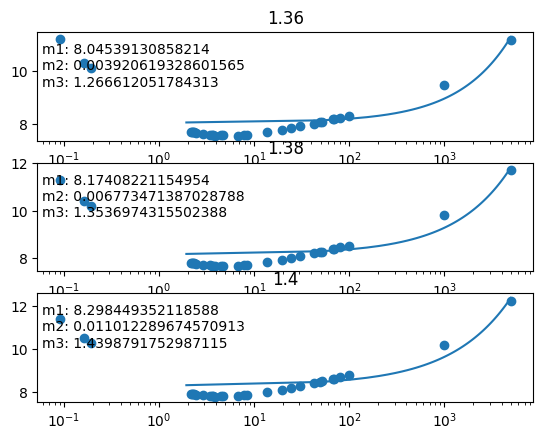

In [15]:
refractive_idxs = [1.36, 1.38, 1.4]

N_vals_interp = np.linspace(N_vals[0] / 4, N_vals[-1], 100)
fig, axs = plt.subplots(len(refractive_idxs), 1)
for i, refractive_idx in enumerate(refractive_idxs):
    m1, m2, m3 = m_params[refractive_idx]
    axs[i].plot(N_vals_interp, m1 + m2*np.exp(np.log(N_vals_interp)/m3))
    axs[i].scatter(N_vals, A_vals[refractive_idx])
    axs[i].set_xscale("log")
    axs[i].set_title(f"{refractive_idx}")
    axs[i].text(0.01, 0.5, f"m1: {m1}\nm2: {m2}\nm3: {m3}", transform=axs[i].transAxes)

plt.show()